In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random


In [2]:
random.seed(42)
np.random.seed(42)

In [ ]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_FIS.csv', index_col=0)

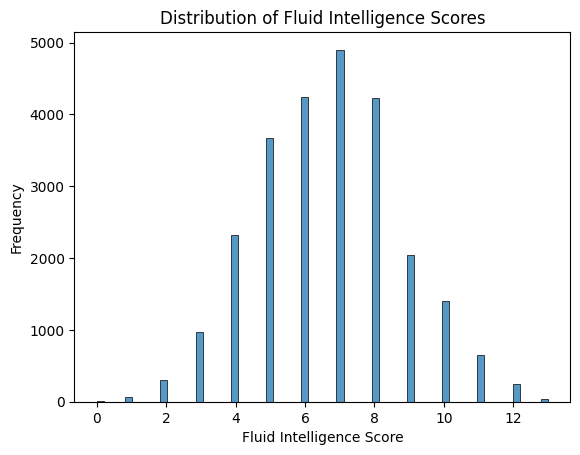

In [4]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

In [5]:
print(len(df))

25095


##### Using MIND to predict Fluid Intelligence Score

In [6]:
# Set X and y

X = df[['31-0.0', '21003-2.0',
        
        'lh_bankssts', 'lh_caudalanteriorcingulate', 'lh_caudalmiddlefrontal',
        'lh_cuneus', 'lh_entorhinal', 'lh_fusiform', 'lh_inferiorparietal', 
        'lh_inferiortemporal', 'lh_isthmuscingulate', 'lh_lateraloccipital', 
        'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 
        'lh_middletemporal', 'lh_parahippocampal', 'lh_paracentral', 
        'lh_parsopercularis', 'lh_parsorbitalis', 'lh_parstriangularis', 
        'lh_pericalcarine', 'lh_postcentral', 'lh_posteriorcingulate', 
        'lh_precentral', 'lh_precuneus', 'lh_rostralanteriorcingulate', 
        'lh_rostralmiddlefrontal', 'lh_superiorfrontal', 'lh_superiorparietal', 
        'lh_superiortemporal', 'lh_supramarginal', 'lh_frontalpole', 
        'lh_temporalpole', 'lh_transversetemporal', 'lh_insula', 
        'rh_bankssts', 'rh_caudalanteriorcingulate', 'rh_caudalmiddlefrontal', 
        'rh_cuneus', 'rh_entorhinal', 'rh_fusiform', 'rh_inferiorparietal', 
        'rh_inferiortemporal', 'rh_isthmuscingulate', 'rh_lateraloccipital', 
        'rh_lateralorbitofrontal', 'rh_lingual', 'rh_medialorbitofrontal', 
        'rh_middletemporal', 'rh_parahippocampal', 'rh_paracentral', 
        'rh_parsopercularis', 'rh_parsorbitalis', 'rh_parstriangularis', 
        'rh_pericalcarine', 'rh_postcentral', 'rh_posteriorcingulate', 
        'rh_precentral', 'rh_precuneus', 'rh_rostralanteriorcingulate', 
        'rh_rostralmiddlefrontal', 'rh_superiorfrontal', 'rh_superiorparietal', 
        'rh_superiortemporal', 'rh_supramarginal', 'rh_frontalpole', 
        'rh_temporalpole', 'rh_transversetemporal', 'rh_insula']]

y = df['20016-2.0']

In [7]:
# Cross-validation set-up
outer_cv = KFold(n_splits=20, shuffle=True, random_state=42)

outer_mae, outer_rmse, outer_r2 = [], [], []
best_params_per_fold = []
nonzero_predictors = []
coefs_list = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner CV
    model = make_pipeline(
        StandardScaler(),
        ElasticNetCV(
            l1_ratio=np.linspace(0.3, 0.9, 7),
            alphas=np.logspace(-4, 2, 20),
            cv=20,
            max_iter=5000,
            random_state=42
        )
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    outer_mae.append(mae)
    outer_rmse.append(rmse)
    outer_r2.append(r2)

    # --- store best α & l1_ratio for this fold ---
    est = model.named_steps['elasticnetcv']
    best_params_per_fold.append(
        {'alpha': est.alpha_, 'l1_ratio': est.l1_ratio_}
    )

    # --- predictors that survived ---
    coefs = est.coef_
    coefs_list.append(coefs)
    surviving = [col for col, c in zip(X.columns, coefs) if c != 0]
    nonzero_predictors.append(surviving)

    print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
          f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')
    

# Aggregate results
print('\n=== 20-fold CV summary ===')
print(f'Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}')
print(f'Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
print(f'Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}')



Fold 01 • MAE=1.642 • RMSE=2.064 • R²=0.022 • α=0.01624 • l1_ratio=0.40
Fold 02 • MAE=1.635 • RMSE=2.034 • R²=0.011 • α=0.01624 • l1_ratio=0.50
Fold 03 • MAE=1.569 • RMSE=1.951 • R²=0.029 • α=0.007848 • l1_ratio=0.40
Fold 04 • MAE=1.622 • RMSE=2.032 • R²=0.021 • α=0.01624 • l1_ratio=0.50
Fold 05 • MAE=1.593 • RMSE=1.991 • R²=0.043 • α=0.0336 • l1_ratio=0.30
Fold 06 • MAE=1.625 • RMSE=2.048 • R²=0.036 • α=0.01624 • l1_ratio=0.50
Fold 07 • MAE=1.609 • RMSE=1.996 • R²=0.032 • α=0.01624 • l1_ratio=0.50
Fold 08 • MAE=1.588 • RMSE=1.974 • R²=0.027 • α=0.01624 • l1_ratio=0.50
Fold 09 • MAE=1.643 • RMSE=2.024 • R²=0.028 • α=0.01624 • l1_ratio=0.50
Fold 10 • MAE=1.681 • RMSE=2.079 • R²=0.032 • α=0.01624 • l1_ratio=0.50
Fold 11 • MAE=1.695 • RMSE=2.113 • R²=0.017 • α=0.01624 • l1_ratio=0.30
Fold 12 • MAE=1.650 • RMSE=2.054 • R²=0.031 • α=0.0336 • l1_ratio=0.30
Fold 13 • MAE=1.616 • RMSE=2.005 • R²=0.035 • α=0.01624 • l1_ratio=0.40
Fold 14 • MAE=1.638 • RMSE=2.041 • R²=0.028 • α=0.01624 • l1_rati

In [8]:
# View parameter choices & surviving variables
param_df = pd.DataFrame(best_params_per_fold)
print('\nBest α and l1_ratio per fold\n', param_df)

print('\nVariables that kept non-zero coefficients in ≥1 fold:')
print(sorted({v for fold_vars in nonzero_predictors for v in fold_vars}))


Best α and l1_ratio per fold
        alpha  l1_ratio
0   0.016238       0.4
1   0.016238       0.5
2   0.007848       0.4
3   0.016238       0.5
4   0.033598       0.3
5   0.016238       0.5
6   0.016238       0.5
7   0.016238       0.5
8   0.016238       0.5
9   0.016238       0.5
10  0.016238       0.3
11  0.033598       0.3
12  0.016238       0.4
13  0.016238       0.3
14  0.016238       0.3
15  0.016238       0.6
16  0.016238       0.5
17  0.016238       0.4
18  0.033598       0.3
19  0.016238       0.5

Variables that kept non-zero coefficients in ≥1 fold:
['21003-2.0', '31-0.0', 'lh_bankssts', 'lh_caudalanteriorcingulate', 'lh_caudalmiddlefrontal', 'lh_cuneus', 'lh_entorhinal', 'lh_frontalpole', 'lh_fusiform', 'lh_inferiorparietal', 'lh_inferiortemporal', 'lh_insula', 'lh_isthmuscingulate', 'lh_lateraloccipital', 'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 'lh_middletemporal', 'lh_paracentral', 'lh_parahippocampal', 'lh_parsopercularis', 'lh_parsorbitalis'

In [9]:
# Final refit on all data
final_model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        l1_ratio=np.linspace(0.3, 0.9, 7),
        alphas=np.logspace(-4, 2, 20),
        cv=20,
        max_iter=5000,
        random_state=42
    )
).fit(X, y)

print('\n=== Final model ===')
print(f"α  = {final_model.named_steps['elasticnetcv'].alpha_:.4g}")
print(f"l1 = {final_model.named_steps['elasticnetcv'].l1_ratio_:.2f}")


=== Final model ===
α  = 0.01624
l1 = 0.50


In [10]:
# Variable-survival summary
flat_survivors  = [v for fold in nonzero_predictors for v in fold]
survivor_counts = Counter(flat_survivors)

print('\n► Number of folds each variable survived')
for var, ct in survivor_counts.items():
    print(f'{var}: {ct}/{len(nonzero_predictors)}')

# print("\n► Survived in >50% of folds")
# for var, ct in survivor_counts.items():
#     if ct > len(nonzero_predictors) / 2:
#         print(var)

# print("\n► Survived in **all** folds")
# for var, ct in survivor_counts.items():
#     if ct == len(nonzero_predictors):
#         print(var)



► Number of folds each variable survived
31-0.0: 20/20
21003-2.0: 20/20
lh_bankssts: 20/20
lh_cuneus: 20/20
lh_entorhinal: 20/20
lh_fusiform: 20/20
lh_inferiortemporal: 20/20
lh_isthmuscingulate: 20/20
lh_lateralorbitofrontal: 20/20
lh_lingual: 8/20
lh_medialorbitofrontal: 6/20
lh_middletemporal: 11/20
lh_parahippocampal: 9/20
lh_paracentral: 20/20
lh_parsopercularis: 17/20
lh_pericalcarine: 20/20
lh_posteriorcingulate: 9/20
lh_rostralanteriorcingulate: 20/20
lh_rostralmiddlefrontal: 16/20
lh_superiorfrontal: 20/20
lh_superiorparietal: 20/20
lh_superiortemporal: 20/20
lh_supramarginal: 20/20
lh_frontalpole: 20/20
lh_temporalpole: 20/20
lh_transversetemporal: 20/20
lh_insula: 20/20
rh_bankssts: 20/20
rh_caudalanteriorcingulate: 20/20
rh_caudalmiddlefrontal: 16/20
rh_cuneus: 20/20
rh_inferiorparietal: 19/20
rh_inferiortemporal: 20/20
rh_isthmuscingulate: 20/20
rh_lateralorbitofrontal: 20/20
rh_lingual: 20/20
rh_medialorbitofrontal: 20/20
rh_middletemporal: 14/20
rh_parahippocampal: 20/2

In [11]:
print(len(nonzero_predictors))
print(np.array(coefs_list).shape)

20
(20, 70)


In [12]:
# Coefficient mean ± 95 % CI
coefs = np.vstack(coefs_list)
#print(coefs.shape)
mean_coefs = coefs.mean(axis=0)
std_coefs = coefs.std(axis=0, ddof=1)
ci95 = 1.96 * std_coefs / np.sqrt(coefs.shape[0])

surv_mask = (coefs != 0).any(axis=0)
surv_vars = np.array(X.columns)[surv_mask]

print('\n► 95% CIs for survivors')
for n, m, ci in zip(
        surv_vars, mean_coefs[surv_mask], ci95[surv_mask]):
    print(f"{n}: {m:.3f} ± {ci:.3f}")




► 95% CIs for survivors
31-0.0: 0.043 ± 0.001
21003-2.0: -0.094 ± 0.001
lh_bankssts: 0.040 ± 0.002
lh_caudalanteriorcingulate: -0.002 ± 0.001
lh_caudalmiddlefrontal: -0.001 ± 0.001
lh_cuneus: 0.012 ± 0.002
lh_entorhinal: -0.009 ± 0.002
lh_fusiform: 0.014 ± 0.002
lh_inferiorparietal: -0.001 ± 0.001
lh_inferiortemporal: 0.050 ± 0.002
lh_isthmuscingulate: -0.047 ± 0.002
lh_lateraloccipital: -0.000 ± 0.000
lh_lateralorbitofrontal: 0.062 ± 0.002
lh_lingual: -0.001 ± 0.001
lh_medialorbitofrontal: -0.001 ± 0.001
lh_middletemporal: -0.004 ± 0.002
lh_parahippocampal: 0.001 ± 0.000
lh_paracentral: 0.010 ± 0.002
lh_parsopercularis: -0.004 ± 0.002
lh_parsorbitalis: -0.000 ± 0.000
lh_pericalcarine: -0.018 ± 0.002
lh_postcentral: 0.001 ± 0.001
lh_posteriorcingulate: 0.001 ± 0.001
lh_precentral: -0.002 ± 0.001
lh_rostralanteriorcingulate: 0.077 ± 0.001
lh_rostralmiddlefrontal: 0.007 ± 0.003
lh_superiorfrontal: 0.024 ± 0.002
lh_superiorparietal: -0.035 ± 0.002
lh_superiortemporal: -0.017 ± 0.002
lh_s

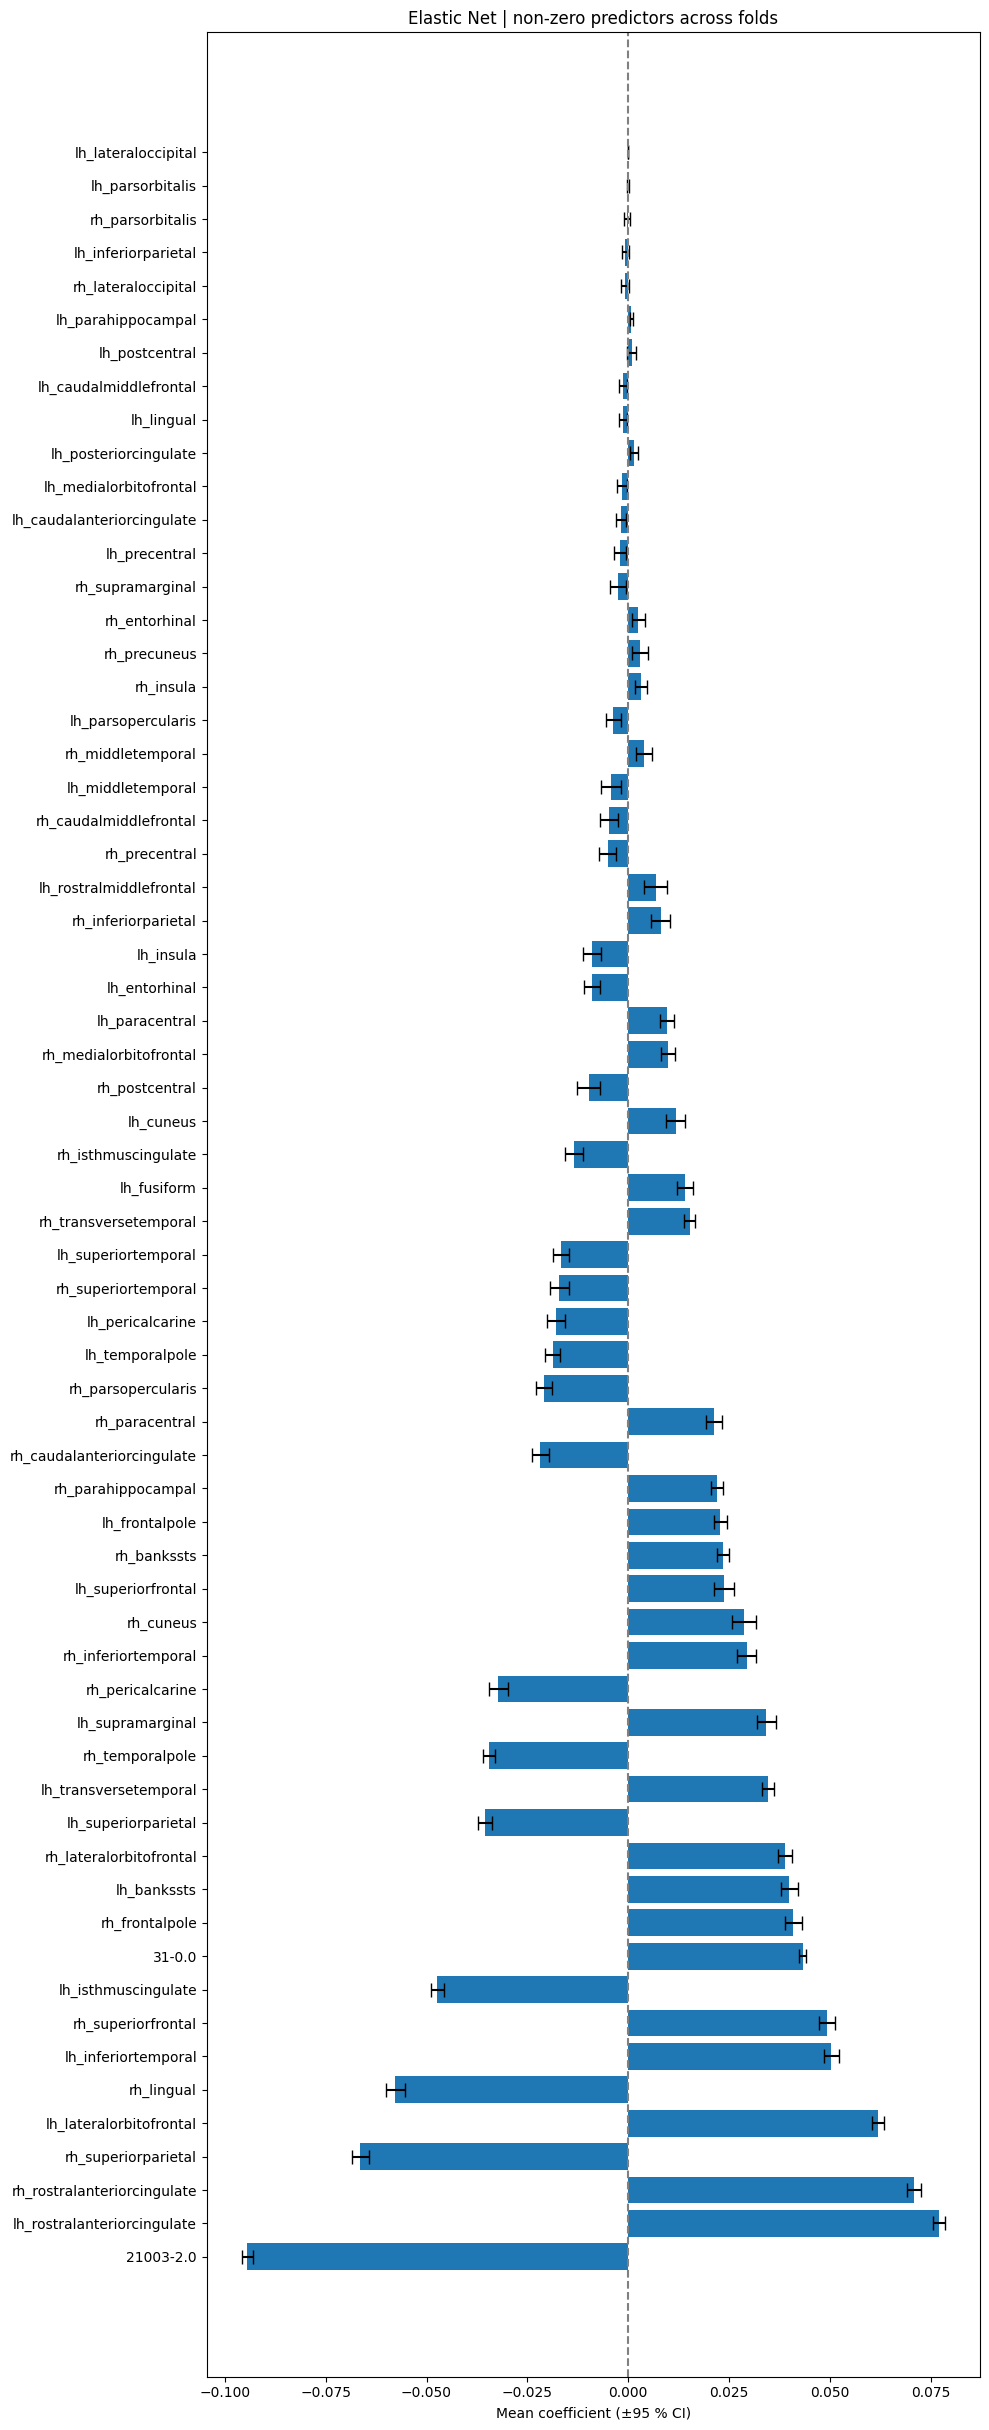

In [13]:
# Bar-plot of coefficient means + CIs
if len(surv_vars):
    order = np.argsort(np.abs(mean_coefs[surv_mask]))[::-1]
    plt.figure(figsize=(10, 0.35 * len(order) + 2))
    plt.barh(
        surv_vars[order],
        mean_coefs[surv_mask][order],
        xerr=ci95[surv_mask][order],
        capsize=5,
        ecolor='black',
    )
    plt.axvline(0, c='grey', ls='--')
    plt.xlabel('Mean coefficient (±95 % CI)')
    plt.title('Elastic Net | non-zero predictors across folds')
    plt.tight_layout()
    plt.show()

else:
    print("Nothing to plot ‒ no variables ever survived.")

In [14]:
# Strict survivors (CI never crosses zero)
low = mean_coefs - ci95
high = mean_coefs + ci95
strict_mask = surv_mask & ((low > 0) | (high < 0))

strict_vars = X.columns[strict_mask]
print(f"\n► {strict_mask.sum()} variables whose 95% CI never crosses 0:")
for n, m, l, h in zip(
        strict_vars,
        mean_coefs[strict_mask],
        low[strict_mask],
        high[strict_mask]):
    print(f"  {n}: {m:.3f}  ({l:.3f} – {h:.3f})")


► 58 variables whose 95% CI never crosses 0:
  31-0.0: 0.043  (0.042 – 0.044)
  21003-2.0: -0.094  (-0.096 – -0.093)
  lh_bankssts: 0.040  (0.038 – 0.042)
  lh_caudalanteriorcingulate: -0.002  (-0.003 – -0.000)
  lh_caudalmiddlefrontal: -0.001  (-0.002 – -0.000)
  lh_cuneus: 0.012  (0.009 – 0.014)
  lh_entorhinal: -0.009  (-0.011 – -0.007)
  lh_fusiform: 0.014  (0.012 – 0.016)
  lh_inferiortemporal: 0.050  (0.048 – 0.052)
  lh_isthmuscingulate: -0.047  (-0.049 – -0.046)
  lh_lateralorbitofrontal: 0.062  (0.060 – 0.063)
  lh_lingual: -0.001  (-0.002 – -0.000)
  lh_medialorbitofrontal: -0.001  (-0.003 – -0.000)
  lh_middletemporal: -0.004  (-0.007 – -0.002)
  lh_parahippocampal: 0.001  (0.000 – 0.001)
  lh_paracentral: 0.010  (0.008 – 0.011)
  lh_parsopercularis: -0.004  (-0.005 – -0.002)
  lh_pericalcarine: -0.018  (-0.020 – -0.016)
  lh_posteriorcingulate: 0.001  (0.000 – 0.002)
  lh_precentral: -0.002  (-0.003 – -0.001)
  lh_rostralanteriorcingulate: 0.077  (0.076 – 0.078)
  lh_rostr

In [15]:
# Re-fit elastic net *only* on strict survivors
if strict_vars.size == 0:
    print("\n⚠️  No strict survivors, skipping refit.")
else:
    X_strict = X[strict_vars]

    outer_cv = KFold(n_splits=20, shuffle=True, random_state=42)
    outer_mae, outer_rmse, outer_r2 = [], [], []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_strict, y), start=1):
        X_strict_train, X_strict_test = X_strict.iloc[train_idx], X_strict.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = make_pipeline(
            StandardScaler(),
            ElasticNetCV(
                l1_ratio=np.linspace(0.3, 0.9, 7),
                alphas=np.logspace(-4, 2, 20),
                cv=20,
                max_iter=5000,
                random_state=42
            )
        )

        model.fit(X_strict_train, y_train)
        y_pred = model.predict(X_strict_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- store best α & l1_ratio for this fold ---
        est = model.named_steps['elasticnetcv']

        print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
              f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')

    print("\n=== Re-fit on strict survivors (20-fold CV) ===")
    print(f"MAE : {np.mean(mae):.3f} ± {np.std(mae):.3f}")
    print(f"RMSE: {np.mean(rmse):.3f} ± {np.std(rmse):.3f}")
    print(f"R²  : {np.mean(r2):.3f} ± {np.std(r2):.3f}")

Fold 01 • MAE=1.643 • RMSE=2.064 • R²=0.022 • α=0.003793 • l1_ratio=0.30
Fold 02 • MAE=1.634 • RMSE=2.033 • R²=0.011 • α=0.007848 • l1_ratio=0.30
Fold 03 • MAE=1.568 • RMSE=1.951 • R²=0.029 • α=0.003793 • l1_ratio=0.30
Fold 04 • MAE=1.620 • RMSE=2.029 • R²=0.023 • α=0.003793 • l1_ratio=0.30
Fold 05 • MAE=1.591 • RMSE=1.988 • R²=0.046 • α=0.001833 • l1_ratio=0.30
Fold 06 • MAE=1.624 • RMSE=2.046 • R²=0.038 • α=0.003793 • l1_ratio=0.30
Fold 07 • MAE=1.609 • RMSE=1.995 • R²=0.033 • α=0.003793 • l1_ratio=0.30
Fold 08 • MAE=1.586 • RMSE=1.973 • R²=0.029 • α=0.001833 • l1_ratio=0.30
Fold 09 • MAE=1.644 • RMSE=2.025 • R²=0.027 • α=0.003793 • l1_ratio=0.30
Fold 10 • MAE=1.680 • RMSE=2.078 • R²=0.034 • α=0.007848 • l1_ratio=0.30
Fold 11 • MAE=1.695 • RMSE=2.113 • R²=0.017 • α=0.007848 • l1_ratio=0.30
Fold 12 • MAE=1.649 • RMSE=2.053 • R²=0.032 • α=0.001833 • l1_ratio=0.30
Fold 13 • MAE=1.616 • RMSE=2.005 • R²=0.035 • α=0.003793 • l1_ratio=0.30
Fold 14 • MAE=1.639 • RMSE=2.042 • R²=0.028 • α=0.0

/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_67444/894458127.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.92])


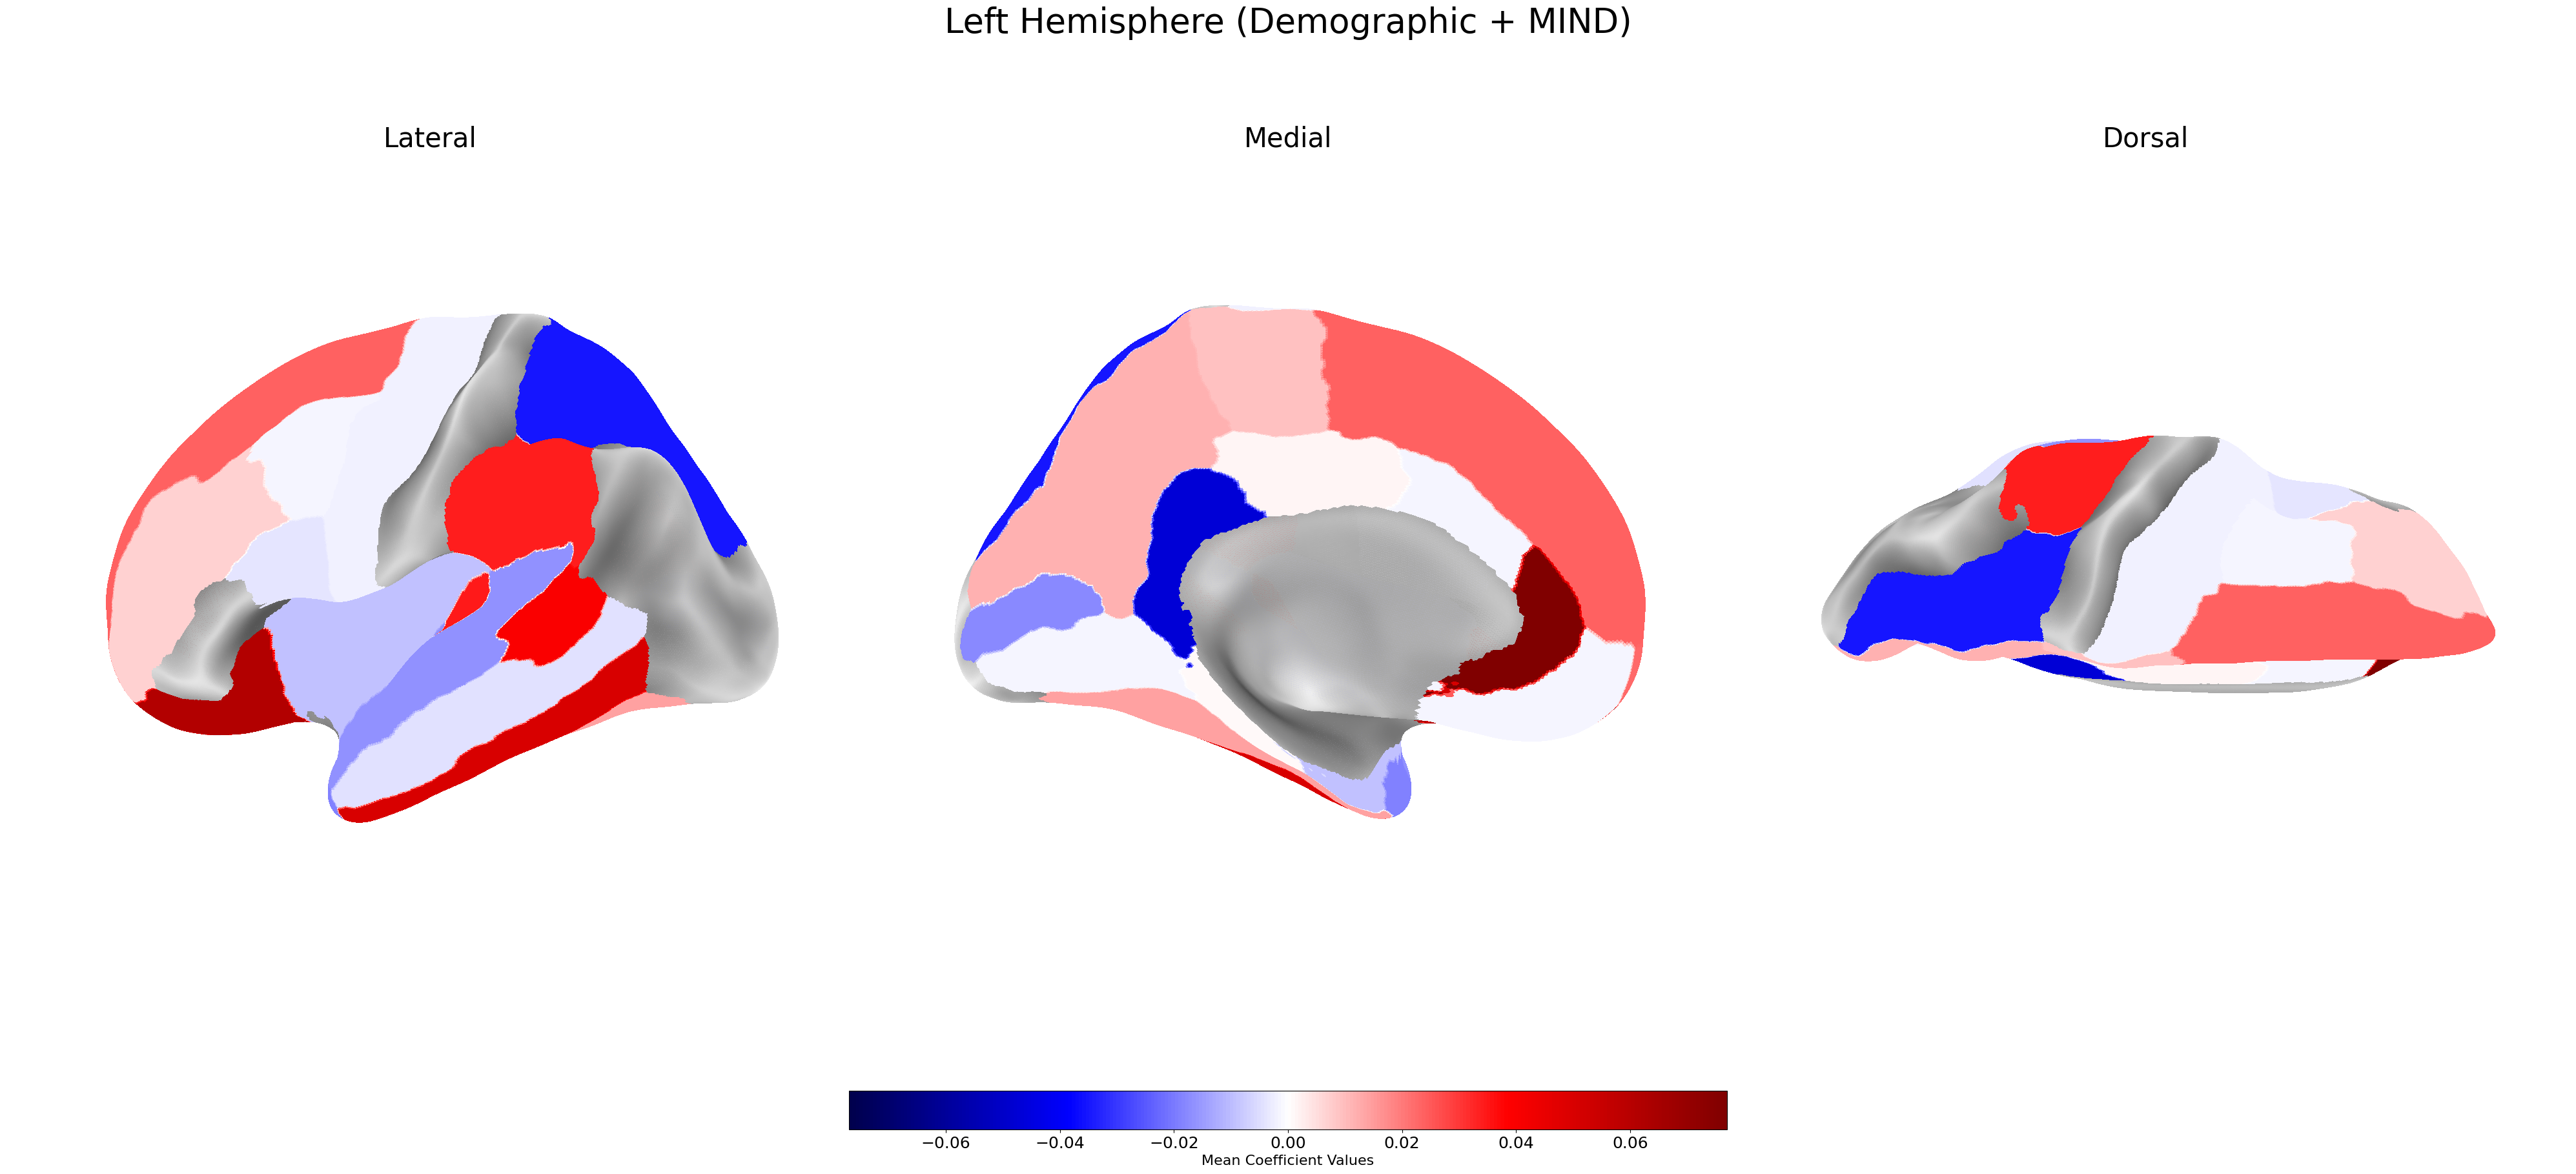

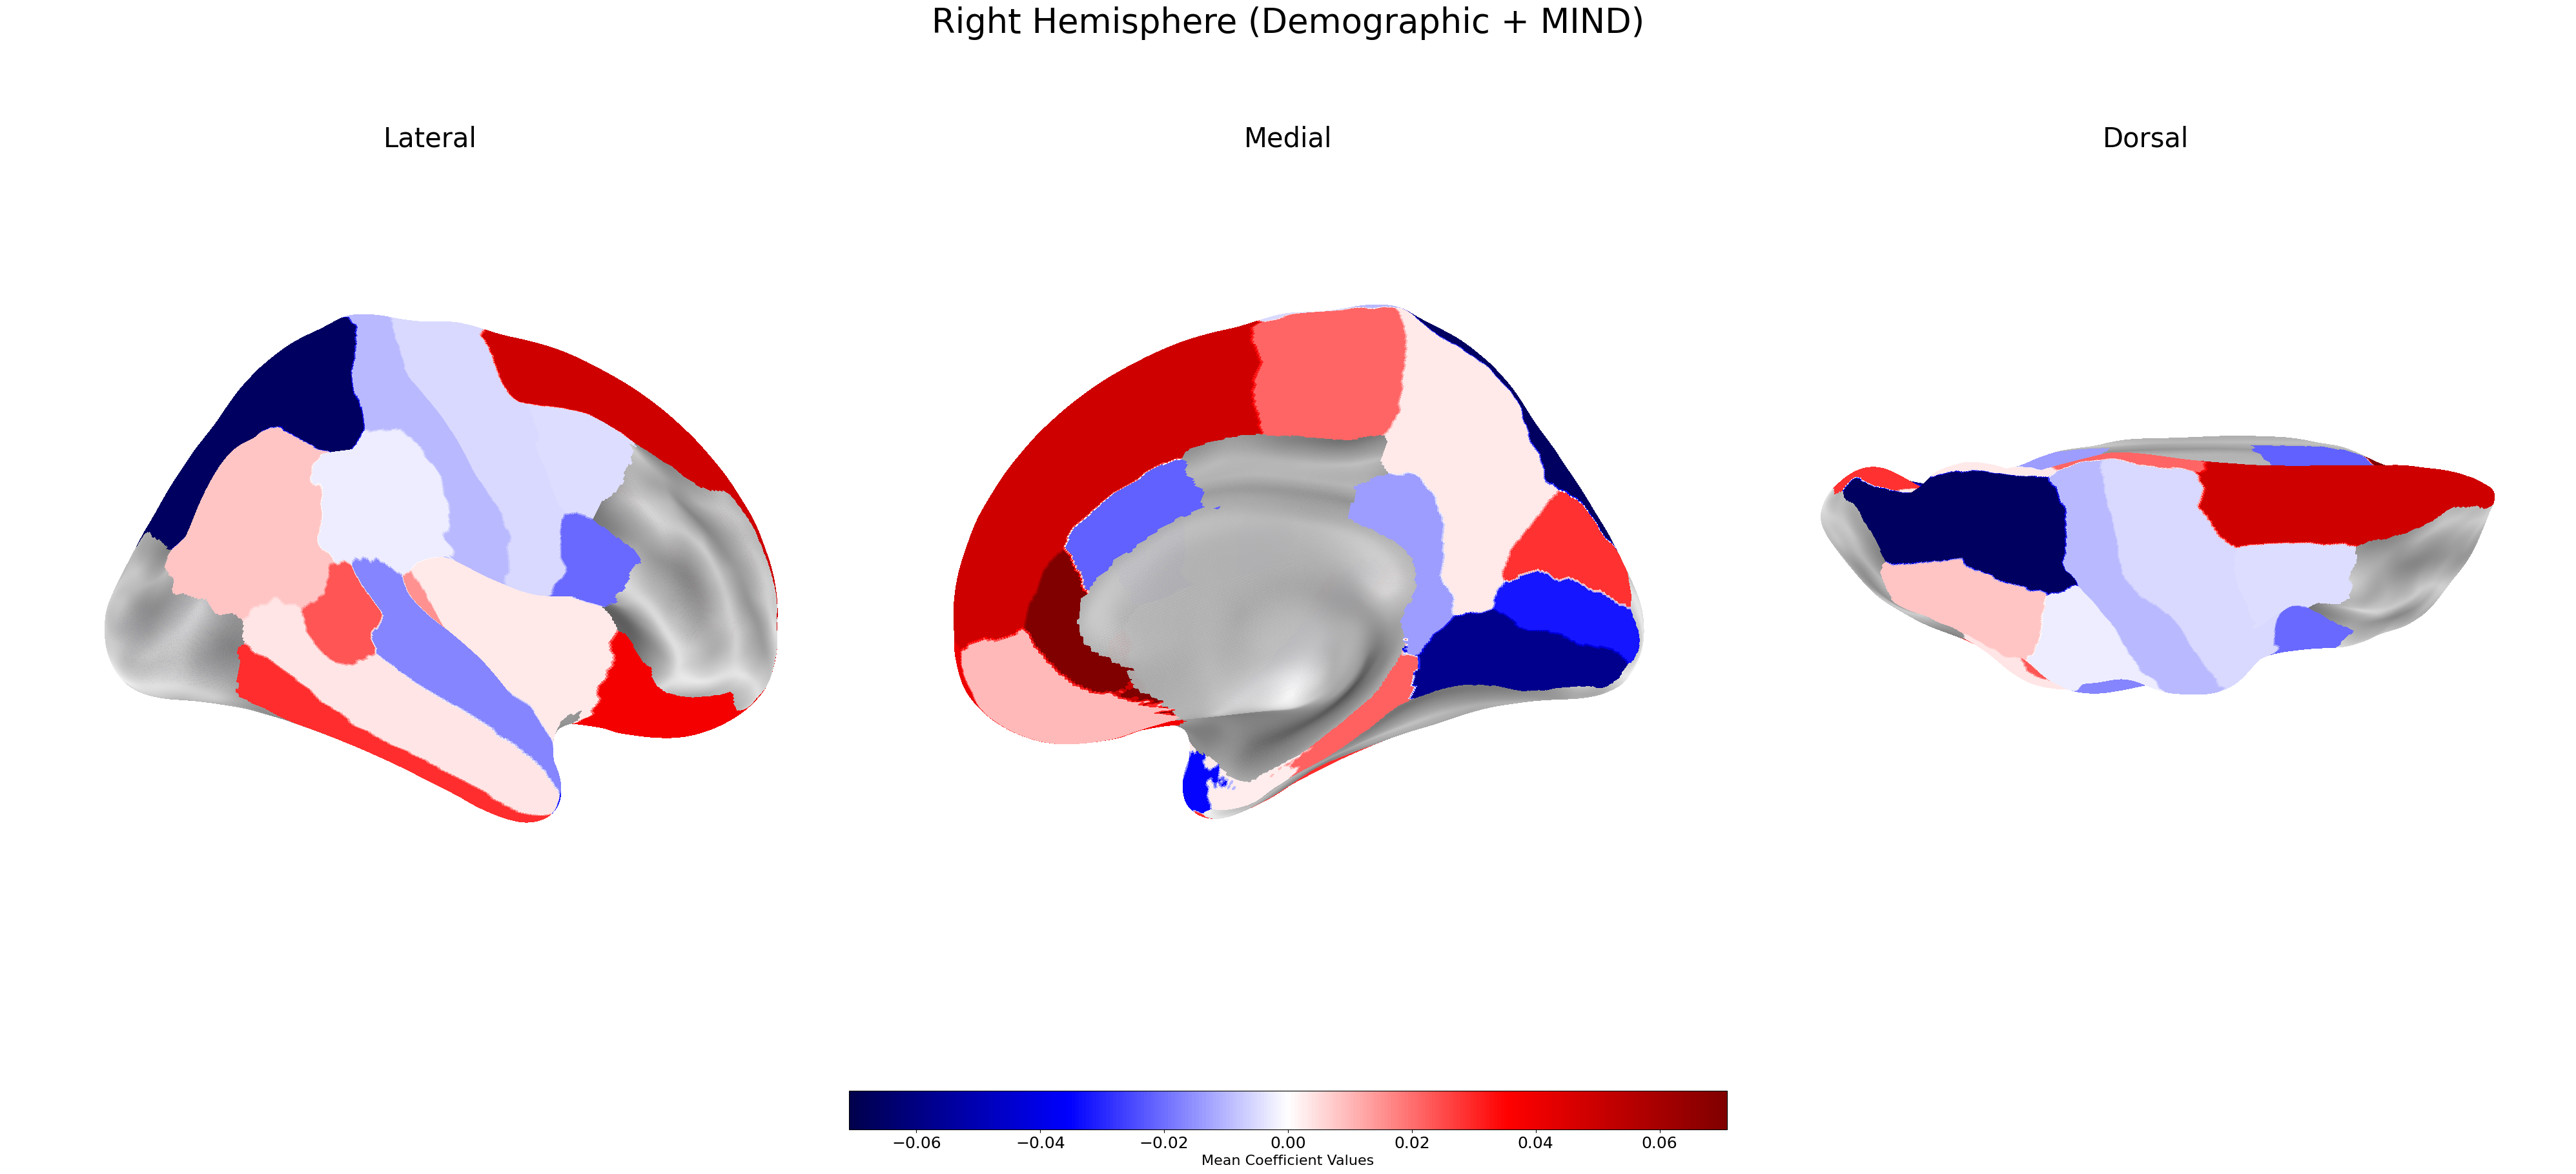

In [16]:
# 1. Variable names and coefficients
if 'strict_vars' in globals() and len(strict_vars):
    vars_to_plot = np.array(strict_vars)
    means = mean_coefs[strict_mask]
    # cis = ci95[strict_mask]
else:
    vars_to_plot = surv_vars
    means = mean_coefs[surv_mask]
    # cis = ci95[surv_mask]

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

# 4. Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

for var, coef in zip(vars_to_plot, means):
    hemi, region = varname_to_region(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = coef
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = coef

# 5. Load inflated_pre surfaces
lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
lh_mesh = (lh_coords, lh_faces)
rh_mesh = (rh_coords, rh_faces)

# 6. Load fsaverage sulcal maps for background
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# 7. Plotting function
def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    vmax = np.nanmax(np.abs(vertex_data))
    cmap = 'seismic'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, vmax=vmax, vmin=-vmax, symmetric_cbar=True,
            view=view, axes=axes[i], title='', figure=fig, alpha=0.9
        )
        axes[i].set_title(view.capitalize(), fontsize=30)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize(vmin=-vmax, vmax=vmax)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('Mean Coefficient Values', fontsize=16)
    cb.ax.tick_params(labelsize=18)
    plt.suptitle(title, fontsize=38, y=0.96)
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    plt.show()

# 8. Plot with inflated_pre
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', 'Left Hemisphere (Demographic + MIND)')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', 'Right Hemisphere (Demographic + MIND)')


##### Using Cortical Thickness to predict Fluid Intelligence Score

In [17]:
X = df[['31-0.0', '21003-2.0',
        
        '27174-2.0', '27267-2.0', '27175-2.0', '27268-2.0', '27176-2.0', '27269-2.0', '27177-2.0',
        '27270-2.0', '27178-2.0', '27271-2.0', '27179-2.0', '27272-2.0', '27180-2.0', '27273-2.0',
        '27204-2.0', '27297-2.0', '27181-2.0', '27274-2.0', '27182-2.0', '27275-2.0', '27183-2.0',
        '27276-2.0', '27184-2.0', '27277-2.0', '27185-2.0', '27278-2.0', '27186-2.0', '27279-2.0',
        '27188-2.0', '27281-2.0', '27187-2.0', '27280-2.0', '27189-2.0', '27282-2.0', '27190-2.0',
        '27283-2.0', '27191-2.0', '27284-2.0', '27192-2.0', '27285-2.0', '27193-2.0', '27286-2.0',
        '27194-2.0', '27287-2.0', '27195-2.0', '27288-2.0', '27196-2.0', '27289-2.0', '27197-2.0',
        '27290-2.0', '27198-2.0', '27291-2.0', '27199-2.0', '27292-2.0', '27200-2.0', '27293-2.0',
        '27201-2.0', '27294-2.0', '27202-2.0', '27295-2.0', '27203-2.0', '27296-2.0']]

y = df['20016-2.0']

In [18]:

datafield_code = ['27174-2.0', '27267-2.0', '27175-2.0', '27268-2.0', '27176-2.0', '27269-2.0', '27177-2.0',
        '27270-2.0', '27178-2.0', '27271-2.0', '27179-2.0', '27272-2.0', '27180-2.0', '27273-2.0',
        '27204-2.0', '27297-2.0', '27181-2.0', '27274-2.0', '27182-2.0', '27275-2.0', '27183-2.0',
        '27276-2.0', '27184-2.0', '27277-2.0', '27185-2.0', '27278-2.0', '27186-2.0', '27279-2.0',
        '27188-2.0', '27281-2.0', '27187-2.0', '27280-2.0', '27189-2.0', '27282-2.0', '27190-2.0',
        '27283-2.0', '27191-2.0', '27284-2.0', '27192-2.0', '27285-2.0', '27193-2.0', '27286-2.0',
        '27194-2.0', '27287-2.0', '27195-2.0', '27288-2.0', '27196-2.0', '27289-2.0', '27197-2.0',
        '27290-2.0', '27198-2.0', '27291-2.0', '27199-2.0', '27292-2.0', '27200-2.0', '27293-2.0',
        '27201-2.0', '27294-2.0', '27202-2.0', '27295-2.0', '27203-2.0', '27296-2.0']

datafield_name = ['lh_caudalanteriorcingulate_thickness', 'rh_caudalanteriorcingulate_thickness', 'lh_caudalmiddlefrontal_thickness',
        'rh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness', 'rh_cuneus_thickness', 'lh_entorhinal_thickness', 
        'rh_entorhinal_thickness', 'lh_fusiform_thickness', 'rh_fusiform_thickness', 'lh_inferiorparietal_thickness', 
        'rh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness', 'rh_inferiortemporal_thickness', 'lh_insula_thickness', 
        'rh_insula_thickness', 'lh_isthmuscingulate_thickness', 'rh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness', 
        'rh_lateraloccipital_thickness', 'lh_lateralorbitofrontal_thickness', 'rh_lateralorbitofrontal_thickness', 
        'lh_lingual_thickness', 'rh_lingual_thickness', 'lh_medialorbitofrontal_thickness', 'rh_medialorbitofrontal_thickness', 
        'lh_middletemporal_thickness', 'rh_middletemporal_thickness', 'lh_paracentral_thickness', 'rh_paracentral_thickness', 
        'lh_parahippocampal_thickness', 'rh_parahippocampal_thickness', 'lh_parsopercularis_thickness', 'rh_parsopercularis_thickness', 
        'lh_parsorbitalis_thickness', 'rh_parsorbitalis_thickness', 'lh_parstriangularis_thickness', 'rh_parstriangularis_thickness', 
        'lh_pericalcarine_thickness', 'rh_pericalcarine_thickness', 'lh_postcentral_thickness', 'rh_postcentral_thickness', 
        'lh_posteriorcingulate_thickness', 'rh_posteriorcingulate_thickness', 'lh_precentral_thickness', 'rh_precentral_thickness', 
        'lh_precuneus_thickness', 'rh_precuneus_thickness', 'lh_rostralanteriorcingulate_thickness', 'rh_rostralanteriorcingulate_thickness', 
        'lh_rostralmiddlefrontal_thickness', 'rh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness', 'rh_superiorfrontal_thickness', 
        'lh_superiorparietal_thickness', 'rh_superiorparietal_thickness', 'lh_superiortemporal_thickness', 'rh_superiortemporal_thickness', 
        'lh_supramarginal_thickness', 'rh_supramarginal_thickness', 'lh_transversetemporal_thickness', 'rh_transversetemporal_thickness']

print(len(datafield_code) == len(datafield_name))

rename_dict = dict(zip(datafield_code, datafield_name))
X = X.rename(columns=rename_dict)

True


In [19]:
# Cross-validation set-up
outer_cv = KFold(n_splits=20, shuffle=True, random_state=42)

outer_mae, outer_rmse, outer_r2 = [], [], []
best_params_per_fold = []
nonzero_predictors = []
coefs_list = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner CV
    model = make_pipeline(
        StandardScaler(),
        ElasticNetCV(
            l1_ratio=np.linspace(0.3, 0.9, 7),
            alphas=np.logspace(-4, 2, 20),
            cv=20,
            max_iter=5000,
            random_state=42
        )
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    outer_mae.append(mae)
    outer_rmse.append(rmse)
    outer_r2.append(r2)

    # --- store best α & l1_ratio for this fold ---
    est = model.named_steps['elasticnetcv']
    best_params_per_fold.append(
        {'alpha': est.alpha_, 'l1_ratio': est.l1_ratio_}
    )

    # --- predictors that survived ---
    coefs = est.coef_
    coefs_list.append(coefs)
    surviving = [col for col, c in zip(X.columns, coefs) if c != 0]
    nonzero_predictors.append(surviving)

    print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
          f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')
    

# Aggregate results
print('\n=== 20-fold CV summary ===')
print(f'Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}')
print(f'Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
print(f'Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}')



Fold 01 • MAE=1.640 • RMSE=2.066 • R²=0.020 • α=0.007848 • l1_ratio=0.40
Fold 02 • MAE=1.632 • RMSE=2.031 • R²=0.014 • α=0.007848 • l1_ratio=0.50
Fold 03 • MAE=1.584 • RMSE=1.964 • R²=0.016 • α=0.007848 • l1_ratio=0.40
Fold 04 • MAE=1.627 • RMSE=2.040 • R²=0.013 • α=0.007848 • l1_ratio=0.50
Fold 05 • MAE=1.606 • RMSE=2.005 • R²=0.030 • α=0.007848 • l1_ratio=0.40
Fold 06 • MAE=1.635 • RMSE=2.053 • R²=0.031 • α=0.007848 • l1_ratio=0.40
Fold 07 • MAE=1.606 • RMSE=2.002 • R²=0.026 • α=0.007848 • l1_ratio=0.40
Fold 08 • MAE=1.593 • RMSE=1.981 • R²=0.020 • α=0.01624 • l1_ratio=0.30
Fold 09 • MAE=1.647 • RMSE=2.032 • R²=0.021 • α=0.007848 • l1_ratio=0.40
Fold 10 • MAE=1.683 • RMSE=2.082 • R²=0.030 • α=0.007848 • l1_ratio=0.40
Fold 11 • MAE=1.701 • RMSE=2.120 • R²=0.011 • α=0.007848 • l1_ratio=0.40
Fold 12 • MAE=1.655 • RMSE=2.063 • R²=0.023 • α=0.01624 • l1_ratio=0.30
Fold 13 • MAE=1.629 • RMSE=2.021 • R²=0.020 • α=0.007848 • l1_ratio=0.50
Fold 14 • MAE=1.651 • RMSE=2.050 • R²=0.020 • α=0.007

In [20]:
# View parameter choices & surviving variables
param_df = pd.DataFrame(best_params_per_fold)
print('\nBest α and l1_ratio per fold\n', param_df)

print('\nVariables that kept non-zero coefficients in ≥1 fold:')
print(sorted({v for fold_vars in nonzero_predictors for v in fold_vars}))


Best α and l1_ratio per fold
        alpha  l1_ratio
0   0.007848       0.4
1   0.007848       0.5
2   0.007848       0.4
3   0.007848       0.5
4   0.007848       0.4
5   0.007848       0.4
6   0.007848       0.4
7   0.016238       0.3
8   0.007848       0.4
9   0.007848       0.4
10  0.007848       0.4
11  0.016238       0.3
12  0.007848       0.5
13  0.007848       0.5
14  0.007848       0.5
15  0.007848       0.5
16  0.016238       0.3
17  0.007848       0.5
18  0.007848       0.5
19  0.007848       0.5

Variables that kept non-zero coefficients in ≥1 fold:
['21003-2.0', '31-0.0', 'lh_caudalanteriorcingulate_thickness', 'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness', 'lh_entorhinal_thickness', 'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness', 'lh_insula_thickness', 'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness', 'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness', 'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness'

In [21]:
# Final refit on all data
final_model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        l1_ratio=np.linspace(0.3, 0.9, 7),
        alphas=np.logspace(-4, 2, 20),
        cv=20,
        max_iter=5000,
        random_state=42
    )
).fit(X, y)

print('\n=== Final model ===')
print(f"α  = {final_model.named_steps['elasticnetcv'].alpha_:.4g}")
print(f"l1 = {final_model.named_steps['elasticnetcv'].l1_ratio_:.2f}")


=== Final model ===
α  = 0.007848
l1 = 0.50


In [22]:
# Variable-survival summary
flat_survivors  = [v for fold in nonzero_predictors for v in fold]
survivor_counts = Counter(flat_survivors)

print('\n► Number of folds each variable survived')
for var, ct in survivor_counts.items():
    print(f'{var}: {ct}/{len(nonzero_predictors)}')

# print("\n► Survived in >50% of folds")
# for var, ct in survivor_counts.items():
#     if ct > len(nonzero_predictors) / 2:
#         print(var)

# print("\n► Survived in **all** folds")
# for var, ct in survivor_counts.items():
#     if ct == len(nonzero_predictors):
#         print(var)



► Number of folds each variable survived
31-0.0: 20/20
21003-2.0: 20/20
rh_caudalanteriorcingulate_thickness: 20/20
lh_caudalmiddlefrontal_thickness: 20/20
rh_caudalmiddlefrontal_thickness: 20/20
lh_cuneus_thickness: 20/20
rh_cuneus_thickness: 20/20
rh_entorhinal_thickness: 20/20
rh_fusiform_thickness: 13/20
lh_inferiorparietal_thickness: 20/20
lh_inferiortemporal_thickness: 20/20
rh_inferiortemporal_thickness: 20/20
lh_insula_thickness: 20/20
lh_isthmuscingulate_thickness: 20/20
lh_lateraloccipital_thickness: 20/20
rh_lateraloccipital_thickness: 20/20
lh_lateralorbitofrontal_thickness: 20/20
rh_lateralorbitofrontal_thickness: 20/20
rh_lingual_thickness: 12/20
lh_medialorbitofrontal_thickness: 20/20
rh_medialorbitofrontal_thickness: 20/20
lh_middletemporal_thickness: 11/20
rh_middletemporal_thickness: 19/20
lh_paracentral_thickness: 9/20
rh_paracentral_thickness: 20/20
lh_parahippocampal_thickness: 20/20
rh_parahippocampal_thickness: 20/20
lh_parsopercularis_thickness: 19/20
rh_parsop

In [23]:
print(len(nonzero_predictors))
print(np.array(coefs_list).shape)

20
(20, 64)


In [24]:
# Coefficient mean ± 95 % CI
coefs = np.vstack(coefs_list)
#print(coefs.shape)
mean_coefs = coefs.mean(axis=0)
std_coefs = coefs.std(axis=0, ddof=1)
ci95 = 1.96 * std_coefs / np.sqrt(coefs.shape[0])

surv_mask = (coefs != 0).any(axis=0)
surv_vars = np.array(X.columns)[surv_mask]

print('\n► 95% CIs for survivors')
for n, m, ci in zip(
        surv_vars, mean_coefs[surv_mask], ci95[surv_mask]):
    print(f"{n}: {m:.3f} ± {ci:.3f}")




► 95% CIs for survivors
31-0.0: 0.111 ± 0.001
21003-2.0: -0.141 ± 0.001
lh_caudalanteriorcingulate_thickness: -0.002 ± 0.001
rh_caudalanteriorcingulate_thickness: -0.037 ± 0.002
lh_caudalmiddlefrontal_thickness: 0.014 ± 0.002
rh_caudalmiddlefrontal_thickness: 0.021 ± 0.002
lh_cuneus_thickness: 0.033 ± 0.002
rh_cuneus_thickness: 0.036 ± 0.002
lh_entorhinal_thickness: 0.000 ± 0.000
rh_entorhinal_thickness: -0.008 ± 0.001
rh_fusiform_thickness: -0.003 ± 0.001
lh_inferiorparietal_thickness: -0.037 ± 0.003
rh_inferiorparietal_thickness: 0.001 ± 0.001
lh_inferiortemporal_thickness: -0.012 ± 0.002
rh_inferiortemporal_thickness: -0.012 ± 0.002
lh_insula_thickness: 0.048 ± 0.002
lh_isthmuscingulate_thickness: -0.017 ± 0.002
rh_isthmuscingulate_thickness: 0.002 ± 0.001
lh_lateraloccipital_thickness: -0.018 ± 0.002
rh_lateraloccipital_thickness: -0.015 ± 0.003
lh_lateralorbitofrontal_thickness: -0.015 ± 0.001
rh_lateralorbitofrontal_thickness: -0.062 ± 0.002
lh_lingual_thickness: 0.000 ± 0.000
r

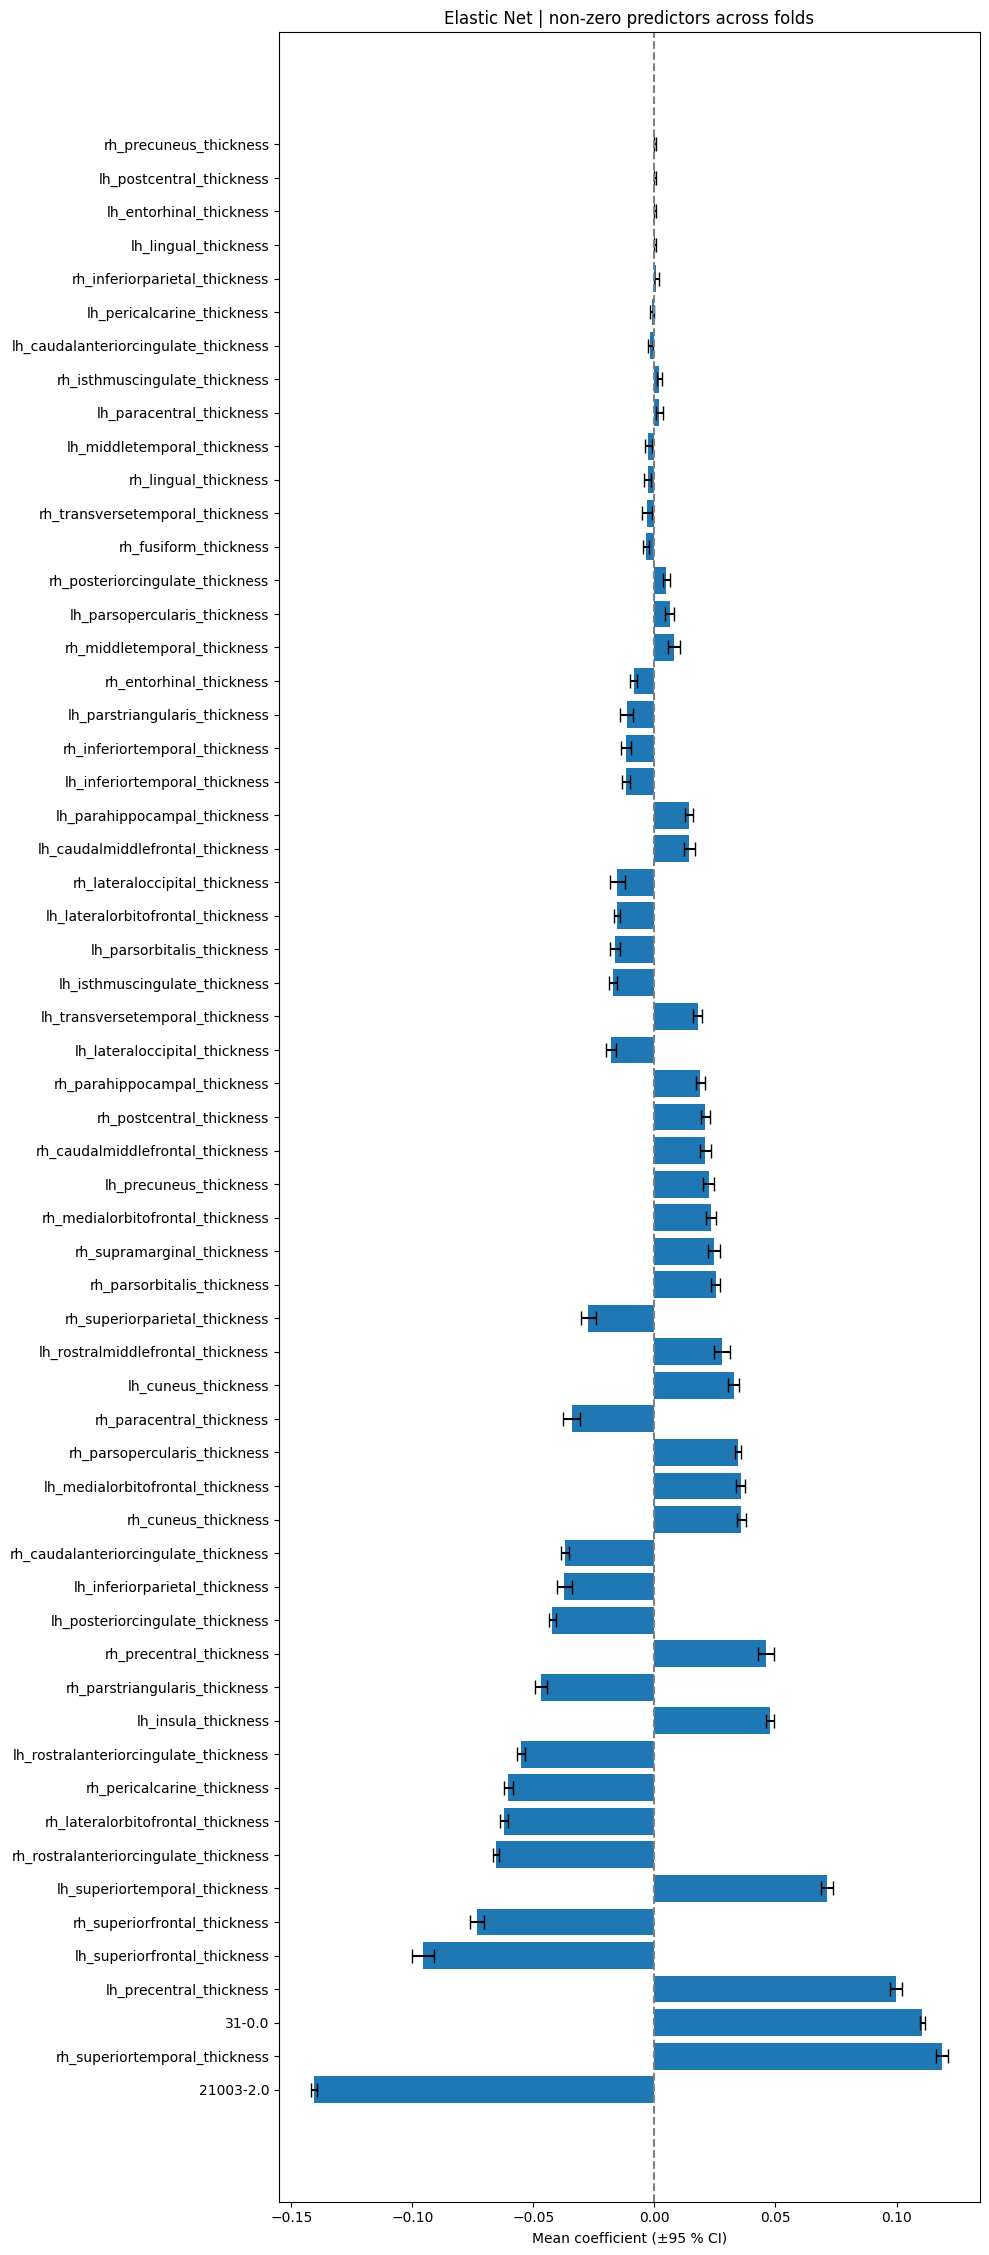

In [25]:
# Bar-plot of coefficient means + CIs
if len(surv_vars):
    order = np.argsort(np.abs(mean_coefs[surv_mask]))[::-1]
    plt.figure(figsize=(10, 0.35 * len(order) + 2))
    plt.barh(
        surv_vars[order],
        mean_coefs[surv_mask][order],
        xerr=ci95[surv_mask][order],
        capsize=5,
        ecolor='black',
    )
    plt.axvline(0, c='grey', ls='--')
    plt.xlabel('Mean coefficient (±95 % CI)')
    plt.title('Elastic Net | non-zero predictors across folds')
    plt.tight_layout()
    plt.show()

else:
    print("Nothing to plot ‒ no variables ever survived.")

In [26]:
# Strict survivors (CI never crosses zero)
low = mean_coefs - ci95
high = mean_coefs + ci95
strict_mask = surv_mask & ((low > 0) | (high < 0))

strict_vars = X.columns[strict_mask]
print(f"\n► {strict_mask.sum()} variables whose 95% CI never crosses 0:")
for n, m, l, h in zip(
        strict_vars,
        mean_coefs[strict_mask],
        low[strict_mask],
        high[strict_mask]):
    print(f"  {n}: {m:.3f}  ({l:.3f} – {h:.3f})")


► 54 variables whose 95% CI never crosses 0:
  31-0.0: 0.111  (0.110 – 0.112)
  21003-2.0: -0.141  (-0.142 – -0.139)
  lh_caudalanteriorcingulate_thickness: -0.002  (-0.003 – -0.001)
  rh_caudalanteriorcingulate_thickness: -0.037  (-0.038 – -0.035)
  lh_caudalmiddlefrontal_thickness: 0.014  (0.012 – 0.017)
  rh_caudalmiddlefrontal_thickness: 0.021  (0.019 – 0.023)
  lh_cuneus_thickness: 0.033  (0.030 – 0.035)
  rh_cuneus_thickness: 0.036  (0.034 – 0.038)
  rh_entorhinal_thickness: -0.008  (-0.010 – -0.007)
  rh_fusiform_thickness: -0.003  (-0.005 – -0.002)
  lh_inferiorparietal_thickness: -0.037  (-0.040 – -0.034)
  lh_inferiortemporal_thickness: -0.012  (-0.014 – -0.010)
  rh_inferiortemporal_thickness: -0.012  (-0.014 – -0.010)
  lh_insula_thickness: 0.048  (0.046 – 0.049)
  lh_isthmuscingulate_thickness: -0.017  (-0.019 – -0.015)
  rh_isthmuscingulate_thickness: 0.002  (0.001 – 0.003)
  lh_lateraloccipital_thickness: -0.018  (-0.020 – -0.016)
  rh_lateraloccipital_thickness: -0.015

In [27]:
# Re-fit elastic net *only* on strict survivors
if strict_vars.size == 0:
    print("\n⚠️  No strict survivors, skipping refit.")
else:
    X_strict = X[strict_vars]

    outer_cv = KFold(n_splits=20, shuffle=True, random_state=42)
    outer_mae, outer_rmse, outer_r2 = [], [], []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_strict, y), start=1):
        X_strict_train, X_strict_test = X_strict.iloc[train_idx], X_strict.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = make_pipeline(
            StandardScaler(),
            ElasticNetCV(
                l1_ratio=np.linspace(0.3, 0.9, 7),
                alphas=np.logspace(-4, 2, 20),
                cv=20,
                max_iter=5000,
                random_state=42
            )
        )

        model.fit(X_strict_train, y_train)
        y_pred = model.predict(X_strict_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- store best α & l1_ratio for this fold ---
        est = model.named_steps['elasticnetcv']

        print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
              f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')

    print("\n=== Re-fit on strict survivors (20-fold CV) ===")
    print(f"MAE : {np.mean(mae):.3f} ± {np.std(mae):.3f}")
    print(f"RMSE: {np.mean(rmse):.3f} ± {np.std(rmse):.3f}")
    print(f"R²  : {np.mean(r2):.3f} ± {np.std(r2):.3f}")

Fold 01 • MAE=1.640 • RMSE=2.066 • R²=0.020 • α=0.007848 • l1_ratio=0.30
Fold 02 • MAE=1.632 • RMSE=2.031 • R²=0.014 • α=0.007848 • l1_ratio=0.30
Fold 03 • MAE=1.584 • RMSE=1.964 • R²=0.016 • α=0.007848 • l1_ratio=0.30
Fold 04 • MAE=1.628 • RMSE=2.041 • R²=0.012 • α=0.003793 • l1_ratio=0.30
Fold 05 • MAE=1.606 • RMSE=2.004 • R²=0.031 • α=0.001833 • l1_ratio=0.30
Fold 06 • MAE=1.634 • RMSE=2.052 • R²=0.032 • α=0.003793 • l1_ratio=0.30
Fold 07 • MAE=1.606 • RMSE=2.002 • R²=0.026 • α=0.003793 • l1_ratio=0.30
Fold 08 • MAE=1.592 • RMSE=1.981 • R²=0.020 • α=0.007848 • l1_ratio=0.30
Fold 09 • MAE=1.647 • RMSE=2.032 • R²=0.021 • α=0.001833 • l1_ratio=0.30
Fold 10 • MAE=1.682 • RMSE=2.081 • R²=0.031 • α=0.003793 • l1_ratio=0.30
Fold 11 • MAE=1.700 • RMSE=2.120 • R²=0.011 • α=0.003793 • l1_ratio=0.30
Fold 12 • MAE=1.653 • RMSE=2.062 • R²=0.024 • α=0.007848 • l1_ratio=0.30
Fold 13 • MAE=1.629 • RMSE=2.021 • R²=0.020 • α=0.007848 • l1_ratio=0.30
Fold 14 • MAE=1.651 • RMSE=2.049 • R²=0.021 • α=0.0

/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_67444/214981938.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.92])


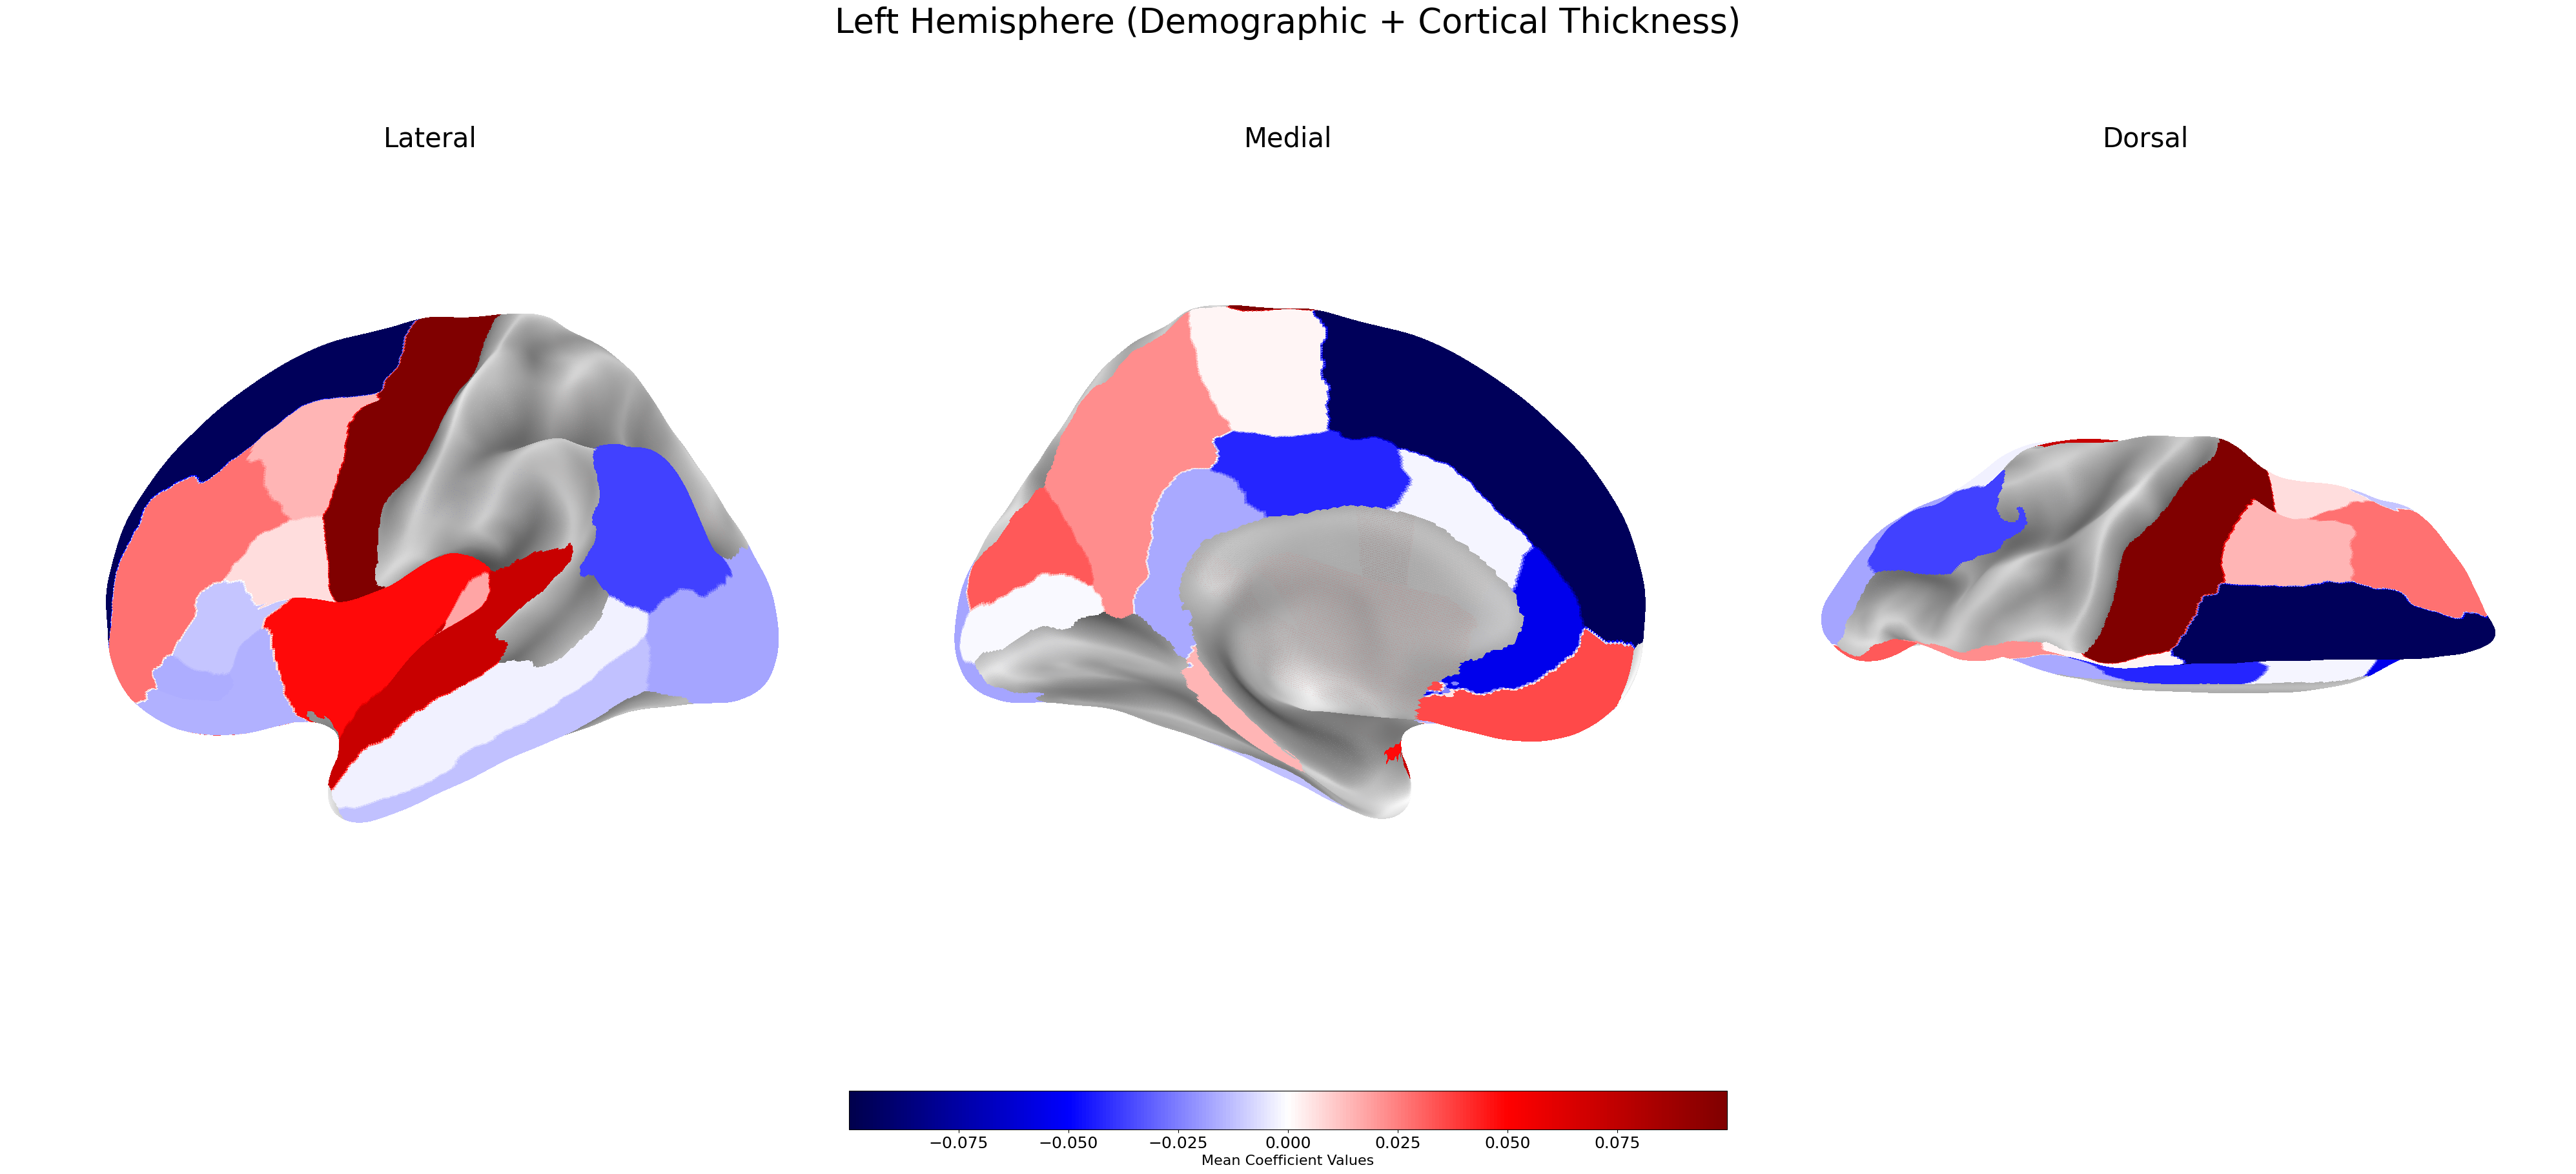

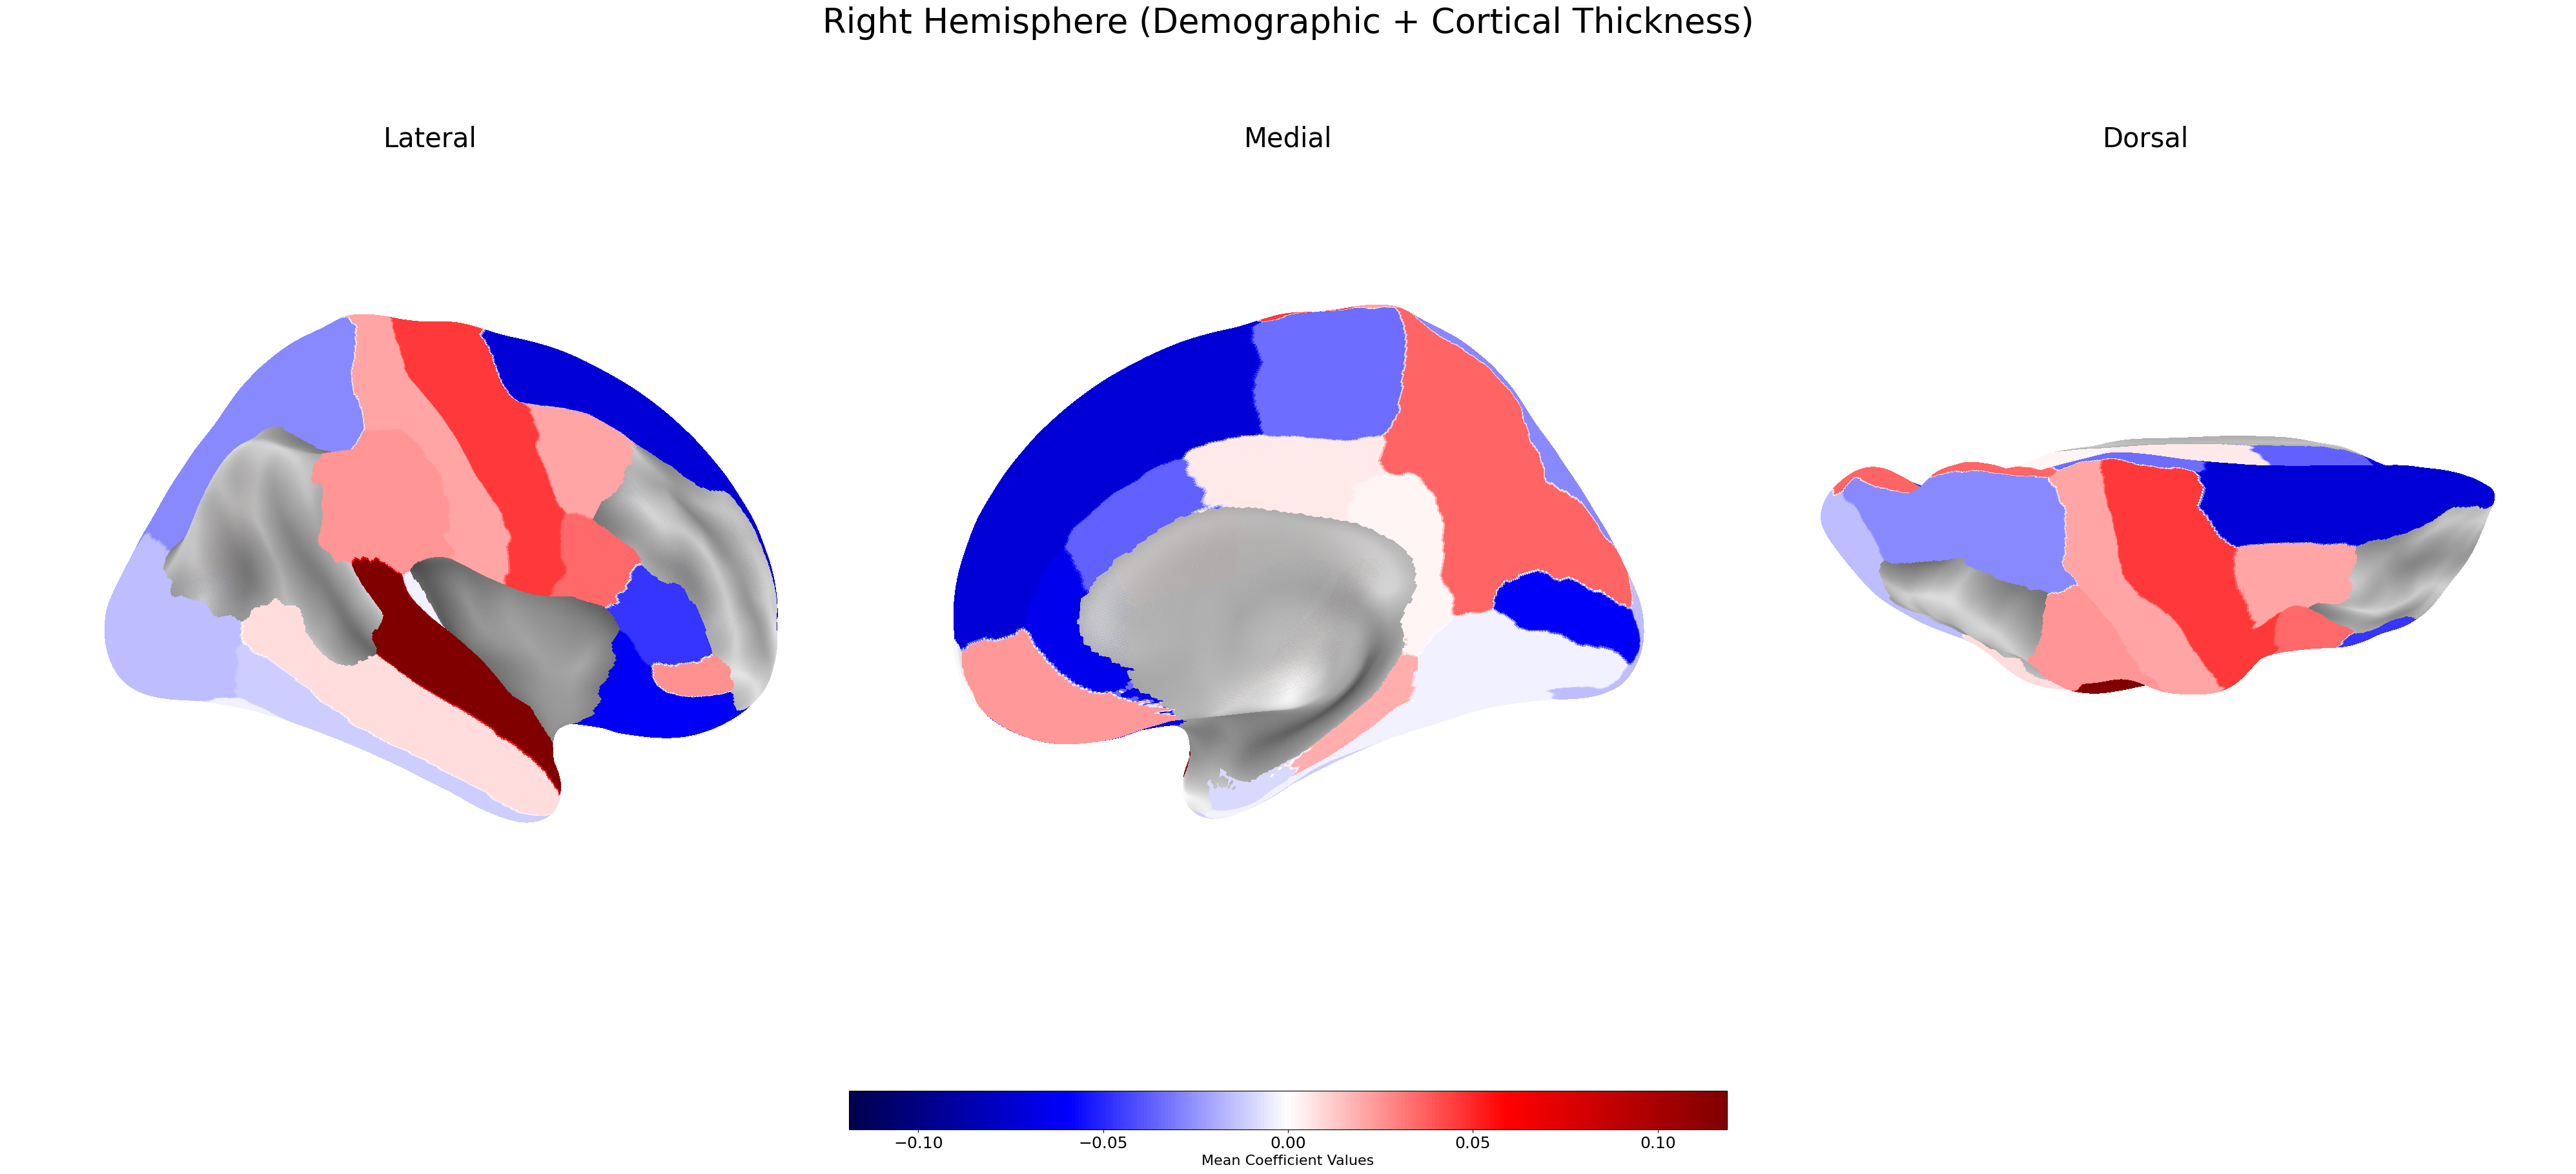

In [28]:
# 1. Variable names and coefficients
if 'strict_vars' in globals() and len(strict_vars):
    vars_to_plot = np.array(strict_vars)
    means = mean_coefs[strict_mask]
    # cis = ci95[strict_mask]
else:
    vars_to_plot = surv_vars
    means = mean_coefs[surv_mask]
    # cis = ci95[surv_mask]

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

# 4. Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

for var, coef in zip(vars_to_plot, means):
    hemi, region = varname_to_region(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = coef
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = coef

# 5. Load inflated_pre surfaces
lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
lh_mesh = (lh_coords, lh_faces)
rh_mesh = (rh_coords, rh_faces)

# 6. Load fsaverage sulcal maps for background
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# 7. Plotting function
def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    vmax = np.nanmax(np.abs(vertex_data))
    cmap = 'seismic'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, vmax=vmax, vmin=-vmax, symmetric_cbar=True,
            view=view, axes=axes[i], title='', figure=fig, alpha=0.9
        )
        axes[i].set_title(view.capitalize(), fontsize=30)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize(vmin=-vmax, vmax=vmax)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('Mean Coefficient Values', fontsize=16)
    cb.ax.tick_params(labelsize=18)
    plt.suptitle(title, fontsize=38, y=0.96)
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    plt.show()

# 8. Plot with inflated_pre
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', 'Left Hemisphere (Demographic + Cortical Thickness)')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', 'Right Hemisphere (Demographic + Cortical Thickness)')
